# Smoothify Visual Tests

Visual comparison of before/after smoothing for all supported Shapely geometry types.

This notebook demonstrates:
- All supported geometry types
- Different smoothing parameters
- Edge cases and special scenarios

In [1]:
import sys
from pathlib import Path

# Add parent directory to path to import smoothify
sys.path.insert(0, str(Path().resolve().parent))

import matplotlib.pyplot as plt
from shapely.geometry import (
    GeometryCollection,
    LinearRing,
    LineString,
    MultiLineString,
    MultiPolygon,
    Polygon,
)

from smoothify import smoothify

# Set up plotting style
plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams["figure.dpi"] = 100

## Helper Functions

In [2]:
def plot_comparison(
    original, smoothed, title="Smoothing Comparison", show_vertices=True
):
    """Plot before and after smoothing side by side."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot original
    plot_geometry(original, ax1, "blue", "Original", show_vertices)

    # Plot smoothed
    plot_geometry(smoothed, ax2, "green", "Smoothed", show_vertices)

    fig.suptitle(title, fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()

    # Print stats
    print_stats(original, smoothed)


def plot_geometry(geom, ax, color, title, show_vertices=True):
    """Plot a single geometry."""
    if isinstance(geom, Polygon):
        plot_polygon(geom, ax, color, show_vertices)
    elif isinstance(geom, LineString):
        plot_linestring(geom, ax, color, show_vertices)
    elif isinstance(geom, LinearRing):
        plot_linearring(geom, ax, color, show_vertices)
    elif isinstance(geom, MultiPolygon):
        for poly in geom.geoms:
            plot_polygon(poly, ax, color, show_vertices)
    elif isinstance(geom, MultiLineString):
        for line in geom.geoms:
            plot_linestring(line, ax, color, show_vertices)
    elif isinstance(geom, GeometryCollection):
        for g in geom.geoms:
            plot_geometry(g, ax, color, title, show_vertices)

    ax.set_aspect("equal")
    ax.set_title(title, fontsize=14)
    ax.grid(True, alpha=0.3)


def plot_polygon(poly, ax, color, show_vertices=True):
    """Plot a polygon with optional vertices."""
    # Exterior
    x, y = poly.exterior.xy
    ax.fill(x, y, alpha=0.3, fc=color, ec=color, linewidth=2)
    if show_vertices:
        ax.plot(x, y, "o", color=color, markersize=4)

    # Holes
    for interior in poly.interiors:
        x, y = interior.xy
        ax.fill(x, y, alpha=1, fc="white", ec=color, linewidth=2)
        if show_vertices:
            ax.plot(x, y, "o", color=color, markersize=4)


def plot_linestring(line, ax, color, show_vertices=True):
    """Plot a linestring with optional vertices."""
    x, y = line.xy
    ax.plot(x, y, color=color, linewidth=2)
    if show_vertices:
        ax.plot(x, y, "o", color=color, markersize=5)
        # Highlight endpoints
        ax.plot(x[0], y[0], "o", color="red", markersize=8, label="Start")
        ax.plot(x[-1], y[-1], "s", color="darkred", markersize=8, label="End")
        ax.legend()


def plot_linearring(ring, ax, color, show_vertices=True):
    """Plot a linear ring."""
    x, y = ring.xy
    ax.plot(x, y, color=color, linewidth=2)
    if show_vertices:
        ax.plot(x, y, "o", color=color, markersize=5)


def print_stats(original, smoothed):
    """Print statistics about the geometries."""
    print(f"\n{'=' * 60}")
    print(f"Geometry Type: {original.geom_type}")
    print(f"{'=' * 60}")

    # Vertex count
    orig_vertices = count_vertices(original)
    smooth_vertices = count_vertices(smoothed)
    print(
        f"Vertices: {orig_vertices} → {smooth_vertices} ({smooth_vertices / orig_vertices:.1f}x increase)"
    )

    # Area/Length
    if hasattr(original, "area") and original.area > 0:
        print(
            f"Area: {original.area:.2f} → {smoothed.area:.2f} (Δ: {abs(original.area - smoothed.area) / original.area * 100:.1f}%)"
        )
    if hasattr(original, "length"):
        print(f"Length: {original.length:.2f} → {smoothed.length:.2f}")

    # Validity
    print(f"Valid: {original.is_valid} → {smoothed.is_valid}")
    print(f"{'=' * 60}\n")


def count_vertices(geom):
    """Count total vertices in a geometry."""
    if isinstance(geom, Polygon):
        count = len(geom.exterior.coords)
        for interior in geom.interiors:
            count += len(interior.coords)
        return count
    elif isinstance(geom, (LineString, LinearRing)):
        return len(geom.coords)
    elif isinstance(geom, (MultiPolygon, MultiLineString, GeometryCollection)):
        return sum(count_vertices(g) for g in geom.geoms)
    return 0

## 1. Simple Polygon

A basic square polygon - demonstrates rounding of sharp corners.

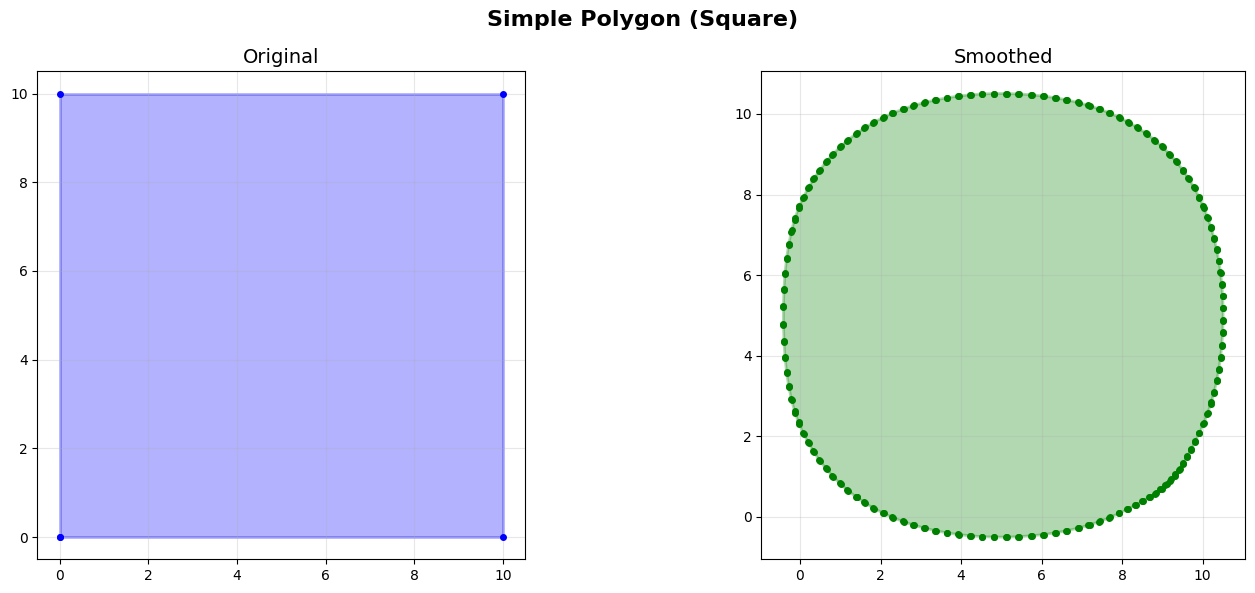


Geometry Type: Polygon
Vertices: 5 → 257 (51.4x increase)
Area: 100.00 → 100.00 (Δ: 0.0%)
Length: 40.00 → 35.56
Valid: True → True



In [3]:
# Create a simple square
square = Polygon([(0, 0), (10, 0), (10, 10), (0, 10)])

# Smooth it
smoothed_square = smoothify(square, segment_length=1.0, smooth_iterations=3)

# Visualize
plot_comparison(square, smoothed_square, "Simple Polygon (Square)")

## 2. Polygon with Pixelated Edges

Simulates a polygon from rasterized data with stair-step edges.

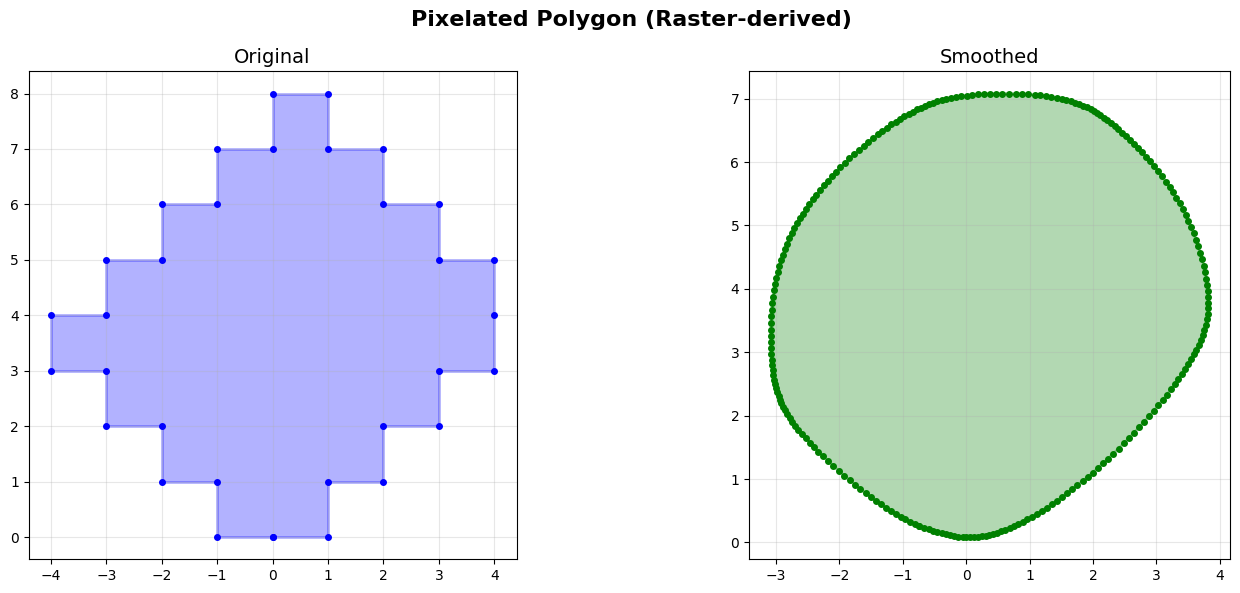


Geometry Type: Polygon
Vertices: 33 → 241 (7.3x increase)
Area: 36.00 → 36.00 (Δ: 0.0%)
Length: 32.00 → 21.42
Valid: True → True



In [4]:
# Create a pixelated polygon (simulating raster-to-vector conversion)
pixelated_coords = [
    (0, 0),
    (1, 0),
    (1, 1),
    (2, 1),
    (2, 2),
    (3, 2),
    (3, 3),
    (4, 3),
    (4, 4),
    (4, 5),
    (3, 5),
    (3, 6),
    (2, 6),
    (2, 7),
    (1, 7),
    (1, 8),
    (0, 8),
    (0, 7),
    (-1, 7),
    (-1, 6),
    (-2, 6),
    (-2, 5),
    (-3, 5),
    (-3, 4),
    (-4, 4),
    (-4, 3),
    (-3, 3),
    (-3, 2),
    (-2, 2),
    (-2, 1),
    (-1, 1),
    (-1, 0),
]
pixelated = Polygon(pixelated_coords)

# Smooth with settings appropriate for 1-unit pixels
smoothed_pixelated = smoothify(
    pixelated, segment_length=1.0, smooth_iterations=4, preserve_area=True
)

plot_comparison(pixelated, smoothed_pixelated, "Pixelated Polygon (Raster-derived)")

## 3. Polygon with Hole

Polygon with an interior hole - both exterior and hole are smoothed independently.

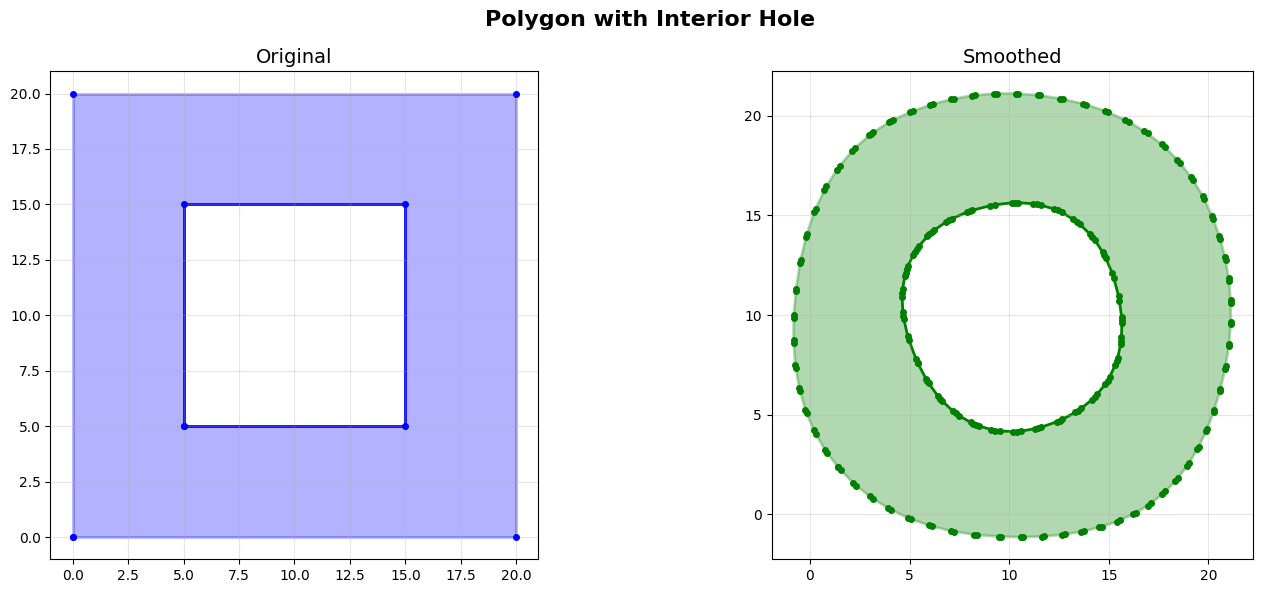


Geometry Type: Polygon
Vertices: 10 → 227 (22.7x increase)
Area: 300.00 → 300.00 (Δ: 0.0%)
Length: 120.00 → 106.63
Valid: True → True



In [5]:
# Create polygon with hole
exterior = [(0, 0), (20, 0), (20, 20), (0, 20)]
hole = [(5, 5), (15, 5), (15, 15), (5, 15)]
poly_with_hole = Polygon(exterior, [hole])

# Smooth it
smoothed_with_hole = smoothify(poly_with_hole, smooth_iterations=3)

plot_comparison(poly_with_hole, smoothed_with_hole, "Polygon with Interior Hole")

## 4. Polygon with Multiple Holes

More complex polygon with multiple interior holes.

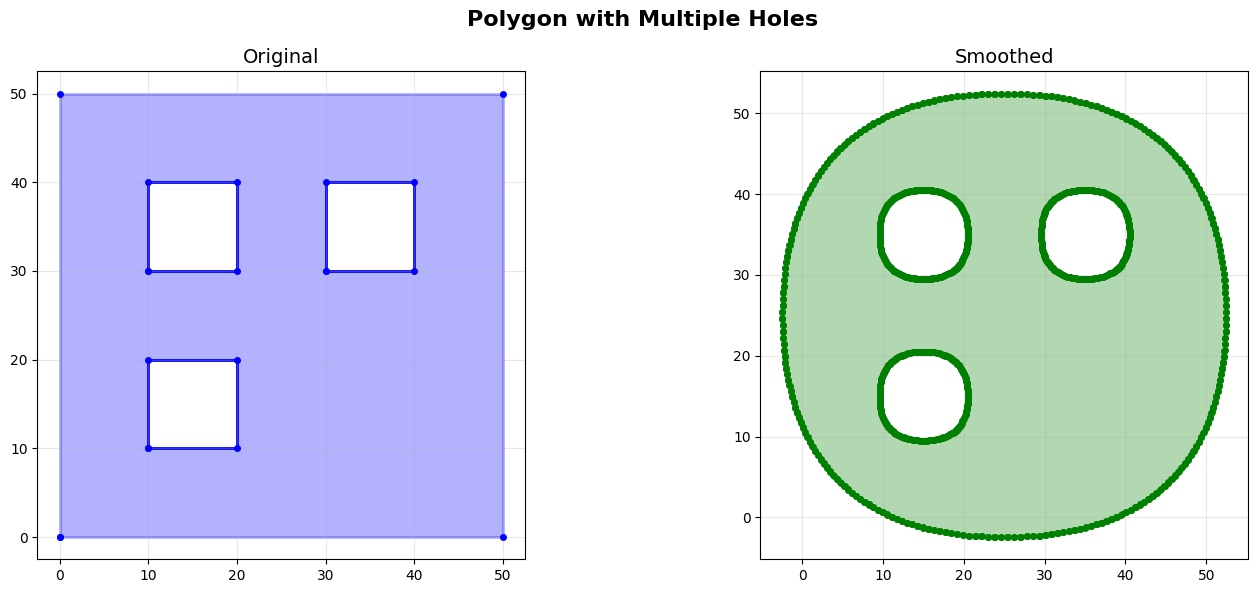


Geometry Type: Polygon
Vertices: 20 → 1284 (64.2x increase)
Area: 2200.00 → 2200.00 (Δ: 0.0%)
Length: 320.00 → 284.42
Valid: True → True



In [6]:
# Create polygon with multiple holes
exterior = [(0, 0), (50, 0), (50, 50), (0, 50)]
hole1 = [(10, 10), (20, 10), (20, 20), (10, 20)]
hole2 = [(30, 30), (40, 30), (40, 40), (30, 40)]
hole3 = [(10, 30), (20, 30), (20, 40), (10, 40)]
multi_hole = Polygon(exterior, [hole1, hole2, hole3])

# Smooth it
smoothed_multi_hole = smoothify(multi_hole, smooth_iterations=3, segment_length=1)

plot_comparison(multi_hole, smoothed_multi_hole, "Polygon with Multiple Holes")

## 5. LineString

Simple zigzag line - endpoints are preserved during smoothing.

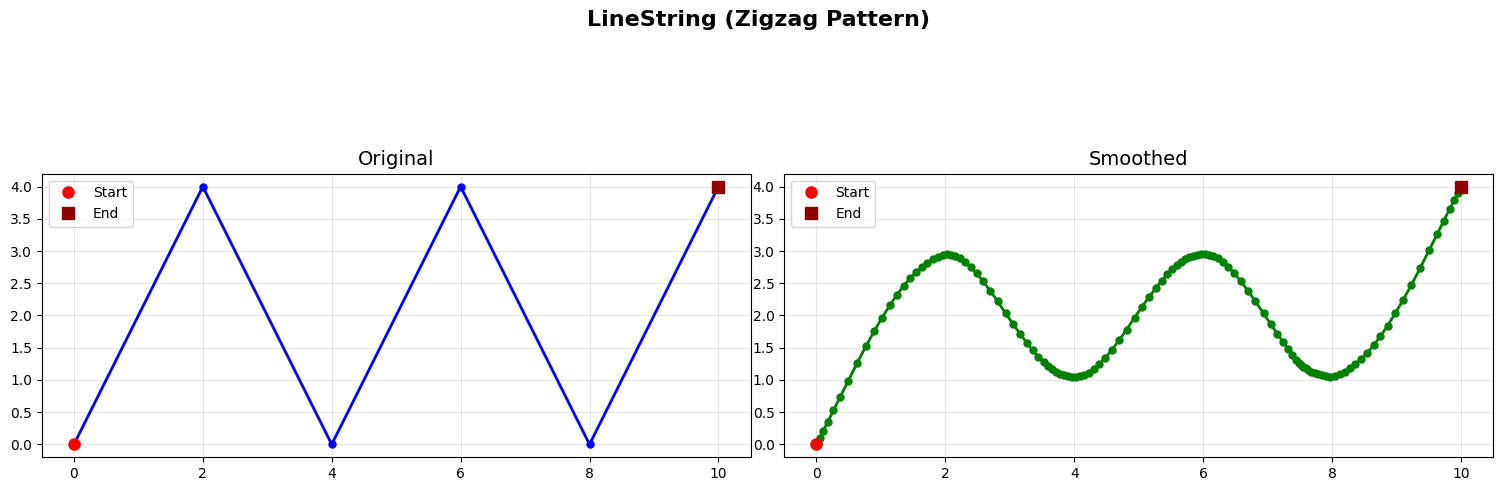


Geometry Type: LineString
Vertices: 6 → 120 (20.0x increase)
Length: 22.36 → 15.87
Valid: True → True



In [7]:
# Create a zigzag linestring
zigzag = LineString([(0, 0), (2, 4), (4, 0), (6, 4), (8, 0), (10, 4)])

# Smooth it
smoothed_zigzag = smoothify(zigzag, segment_length=0.5, smooth_iterations=3)

plot_comparison(zigzag, smoothed_zigzag, "LineString (Zigzag Pattern)")

## 6. Complex LineString

LineString simulating a pixelated road or river from raster data.

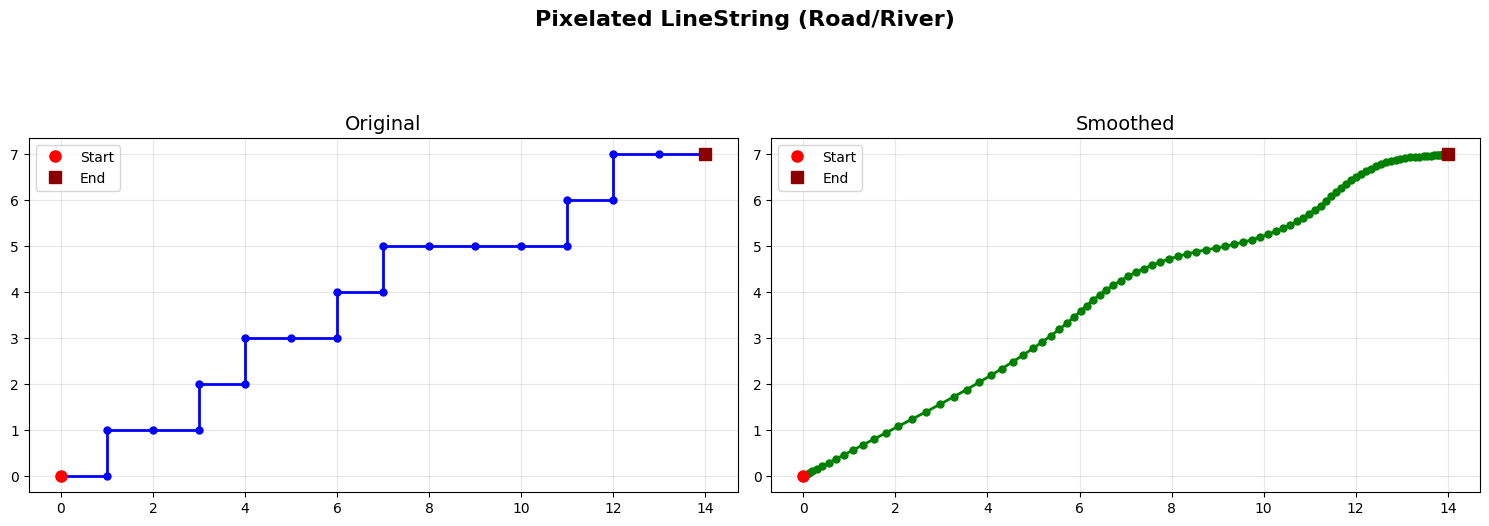


Geometry Type: LineString
Vertices: 22 → 96 (4.4x increase)
Length: 21.00 → 15.88
Valid: True → True



In [8]:
# Create pixelated linestring (like a road from classified imagery)
road_coords = [
    (0, 0),
    (1, 0),
    (1, 1),
    (2, 1),
    (3, 1),
    (3, 2),
    (4, 2),
    (4, 3),
    (5, 3),
    (6, 3),
    (6, 4),
    (7, 4),
    (7, 5),
    (8, 5),
    (9, 5),
    (10, 5),
    (11, 5),
    (11, 6),
    (12, 6),
    (12, 7),
    (13, 7),
    (14, 7),
]
pixelated_road = LineString(road_coords)

# Smooth it
smoothed_road = smoothify(pixelated_road, segment_length=1.0, smooth_iterations=4)

plot_comparison(pixelated_road, smoothed_road, "Pixelated LineString (Road/River)")

## 7. LinearRing

A closed ring geometry (like a polygon boundary without the polygon).

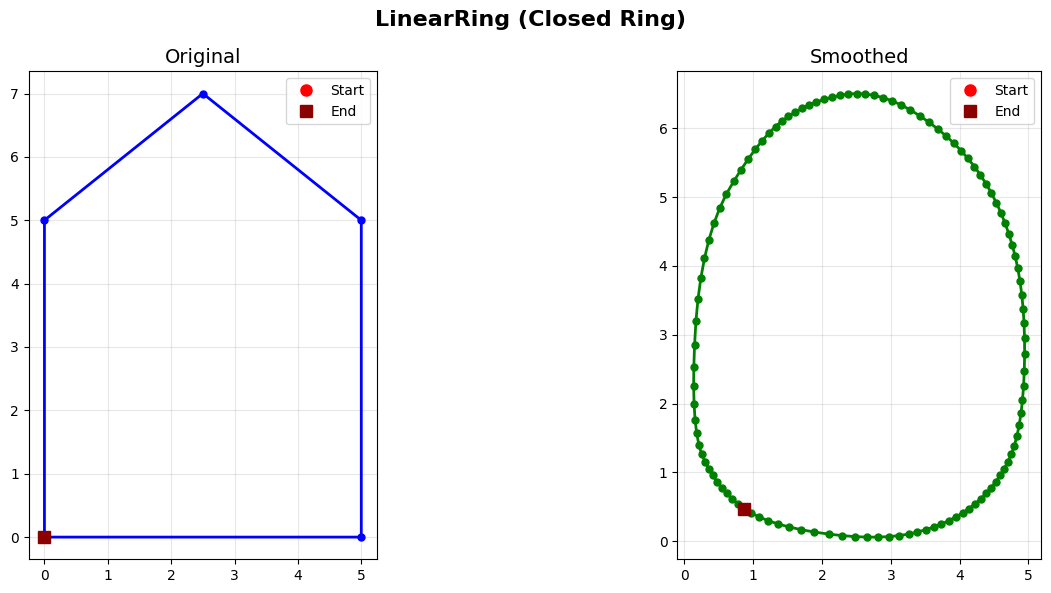


Geometry Type: LinearRing
Vertices: 6 → 113 (18.8x increase)
Length: 21.40 → 18.25
Valid: True → True



In [9]:
# Create a linear ring (closed ring without polygon semantics)
ring_coords = [(0, 0), (5, 0), (5, 5), (2.5, 7), (0, 5)]
ring = LinearRing(ring_coords)

# Smooth it
smoothed_ring = smoothify(ring, segment_length=1, smooth_iterations=3)

plot_comparison(ring, smoothed_ring, "LinearRing (Closed Ring)")

## 8. MultiPolygon (Separate)

Multiple separate polygons smoothed independently.

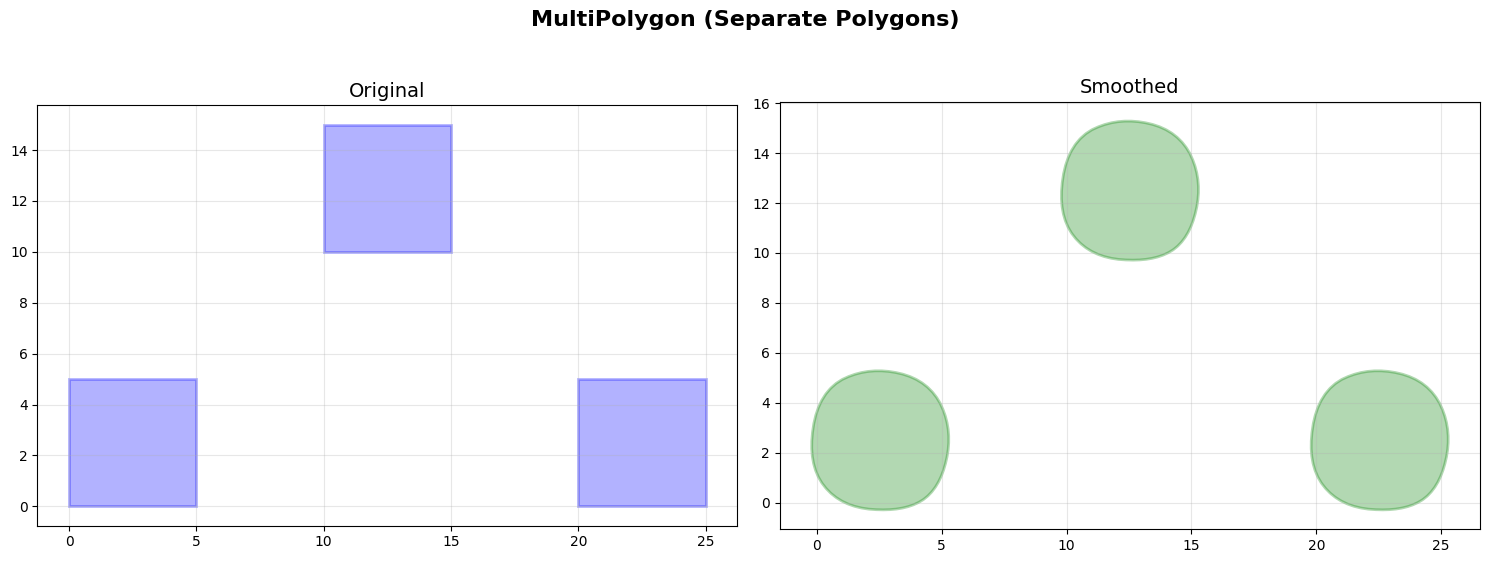


Geometry Type: MultiPolygon
Vertices: 15 → 393 (26.2x increase)
Area: 75.00 → 75.00 (Δ: 0.0%)
Length: 60.00 → 53.30
Valid: True → True



In [10]:
# Create separate polygons
poly1 = Polygon([(0, 0), (5, 0), (5, 5), (0, 5)])
poly2 = Polygon([(10, 10), (15, 10), (15, 15), (10, 15)])
poly3 = Polygon([(20, 0), (25, 0), (25, 5), (20, 5)])
multi = MultiPolygon([poly1, poly2, poly3])

# Smooth without merging

smoothed_multi = smoothify(
    multi, segment_length=1.5, smooth_iterations=3, merge_multipolygons=False
)

plot_comparison(
    multi, smoothed_multi, "MultiPolygon (Separate Polygons)", show_vertices=False
)

## 9. MultiPolygon (Adjacent with Merge)

Adjacent polygons merged before smoothing to avoid boundary artifacts.

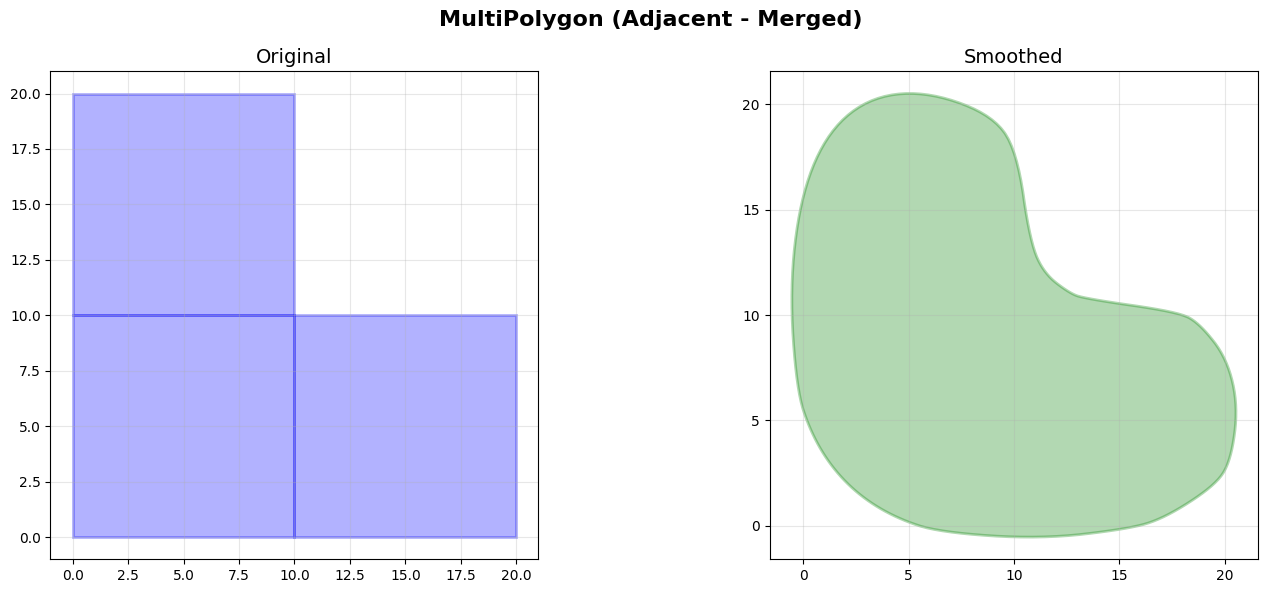


Geometry Type: MultiPolygon
Vertices: 15 → 386 (25.7x increase)
Area: 300.00 → 300.08 (Δ: 0.0%)
Length: 120.00 → 68.73
Valid: False → True



In [11]:
# Create adjacent polygons (like water bodies from adjacent raster cells)
poly1 = Polygon([(0, 0), (10, 0), (10, 10), (0, 10)])
poly2 = Polygon([(10, 0), (20, 0), (20, 10), (10, 10)])
poly3 = Polygon([(0, 10), (10, 10), (10, 20), (0, 20)])
adjacent_multi = MultiPolygon([poly1, poly2, poly3])

# Smooth WITH merging
smoothed_merged = smoothify(
    adjacent_multi, segment_length=1.0, smooth_iterations=3, merge_multipolygons=True
)

plot_comparison(
    adjacent_multi,
    smoothed_merged,
    "MultiPolygon (Adjacent - Merged)",
    show_vertices=False,
)

## 10. GeometryCollection of 3 Polygons (Adjacent with Merge)

Adjacent polygons merged before smoothing to avoid boundary artifacts.

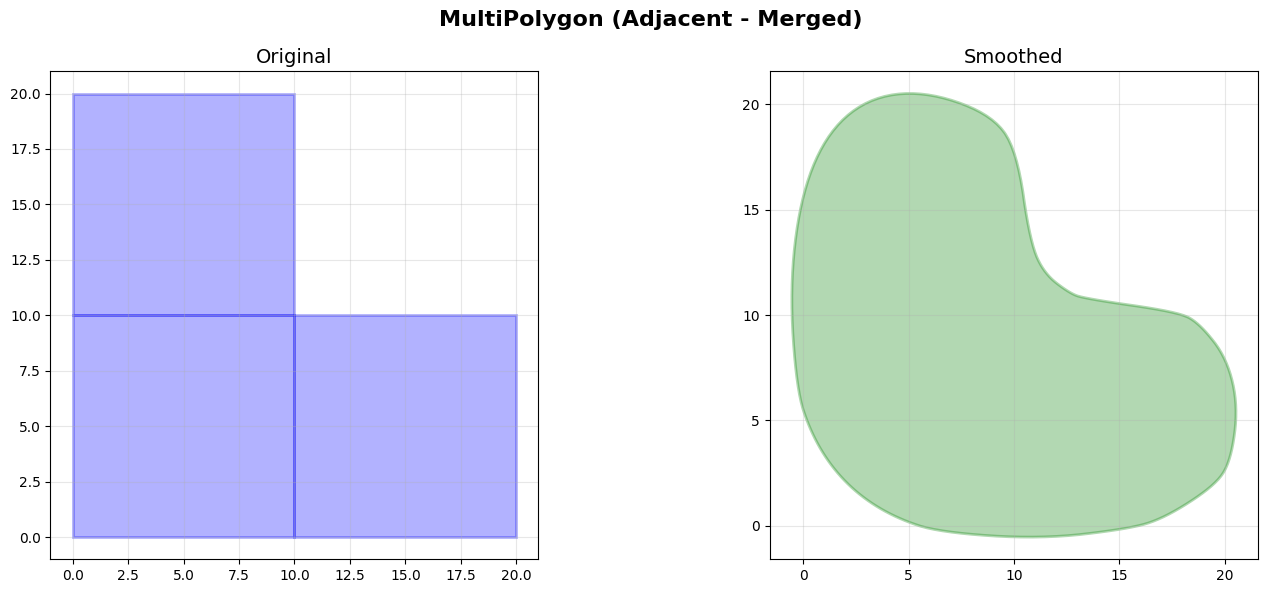


Geometry Type: GeometryCollection
Vertices: 15 → 386 (25.7x increase)
Area: 300.00 → 300.08 (Δ: 0.0%)
Length: 120.00 → 68.73
Valid: True → True



In [12]:
# Create adjacent polygons (like water bodies from adjacent raster cells)
poly1 = Polygon([(0, 0), (10, 0), (10, 10), (0, 10)])
poly2 = Polygon([(10, 0), (20, 0), (20, 10), (10, 10)])
poly3 = Polygon([(0, 10), (10, 10), (10, 20), (0, 20)])
adjacent_multi = GeometryCollection([poly1, poly2, poly3])

# Smooth WITH merging
smoothed_merged = smoothify(
    adjacent_multi, segment_length=1.0, smooth_iterations=3, merge_collection=True
)

plot_comparison(
    adjacent_multi,
    smoothed_merged,
    "MultiPolygon (Adjacent - Merged)",
    show_vertices=False,
)


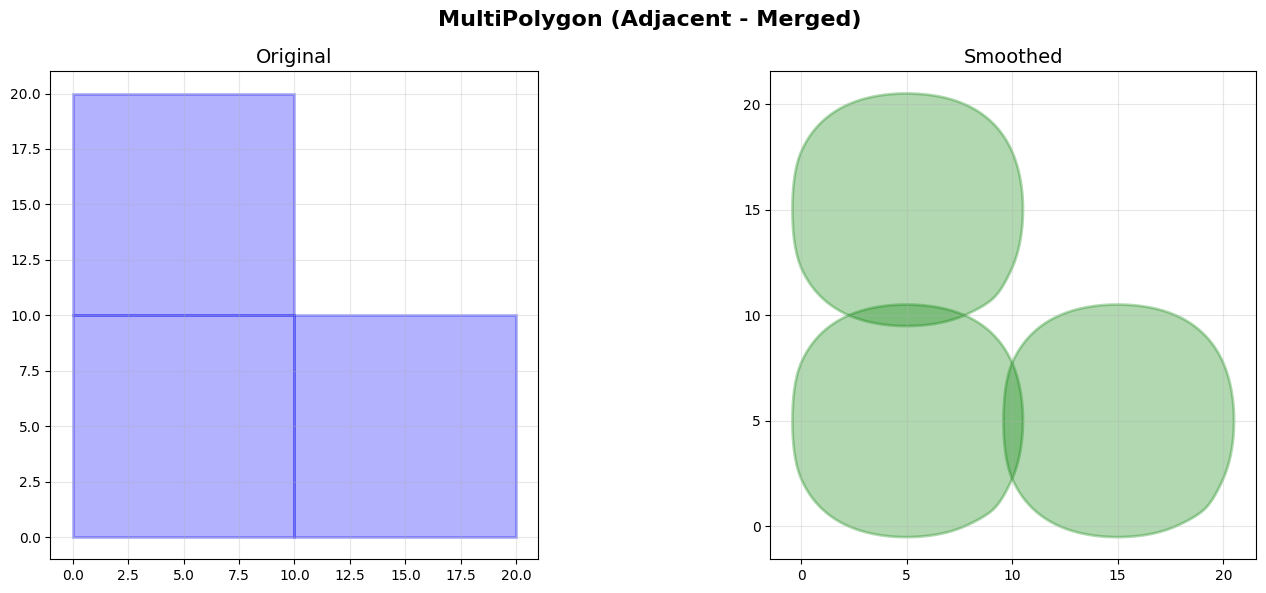


Geometry Type: GeometryCollection
Vertices: 15 → 771 (51.4x increase)
Area: 300.00 → 300.00 (Δ: 0.0%)
Length: 120.00 → 106.69
Valid: True → True



In [13]:
# Create adjacent polygons (like water bodies from adjacent raster cells)
poly1 = Polygon([(0, 0), (10, 0), (10, 10), (0, 10)])
poly2 = Polygon([(10, 0), (20, 0), (20, 10), (10, 10)])
poly3 = Polygon([(0, 10), (10, 10), (10, 20), (0, 20)])
adjacent_multi = GeometryCollection([poly1, poly2, poly3])

# Smooth WITH merging
smoothed_merged = smoothify(
    adjacent_multi, segment_length=1.0, smooth_iterations=3, merge_collection=False
)

plot_comparison(
    adjacent_multi,
    smoothed_merged,
    "MultiPolygon (Adjacent - Merged)",
    show_vertices=False,
)


## 11. MultiLineString

Multiple linestrings smoothed independently.

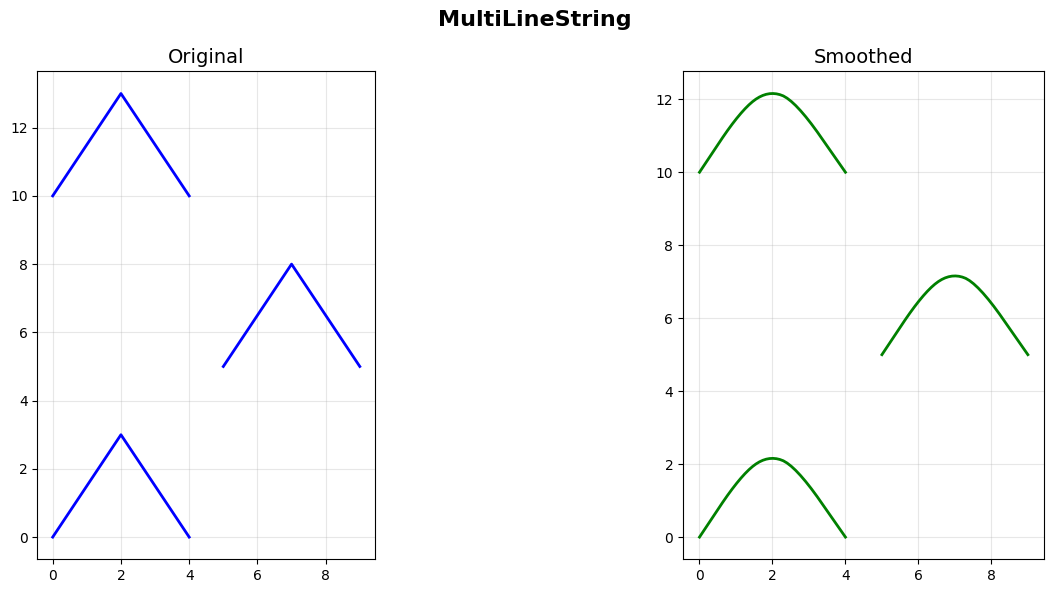


Geometry Type: MultiLineString
Vertices: 9 → 120 (13.3x increase)
Length: 21.63 → 18.15
Valid: True → True



In [14]:
# Create multiple lines
line1 = LineString([(0, 0), (2, 3), (4, 0)])
line2 = LineString([(5, 5), (7, 8), (9, 5)])
line3 = LineString([(0, 10), (2, 13), (4, 10)])
multi_line = MultiLineString([line1, line2, line3])

# Smooth it
smoothed_multi_line = smoothify(multi_line, segment_length=0.5, smooth_iterations=3)

plot_comparison(multi_line, smoothed_multi_line, "MultiLineString", show_vertices=False)

## 12. GeometryCollection (Mixed Types)

Collection containing both polygons and linestrings.

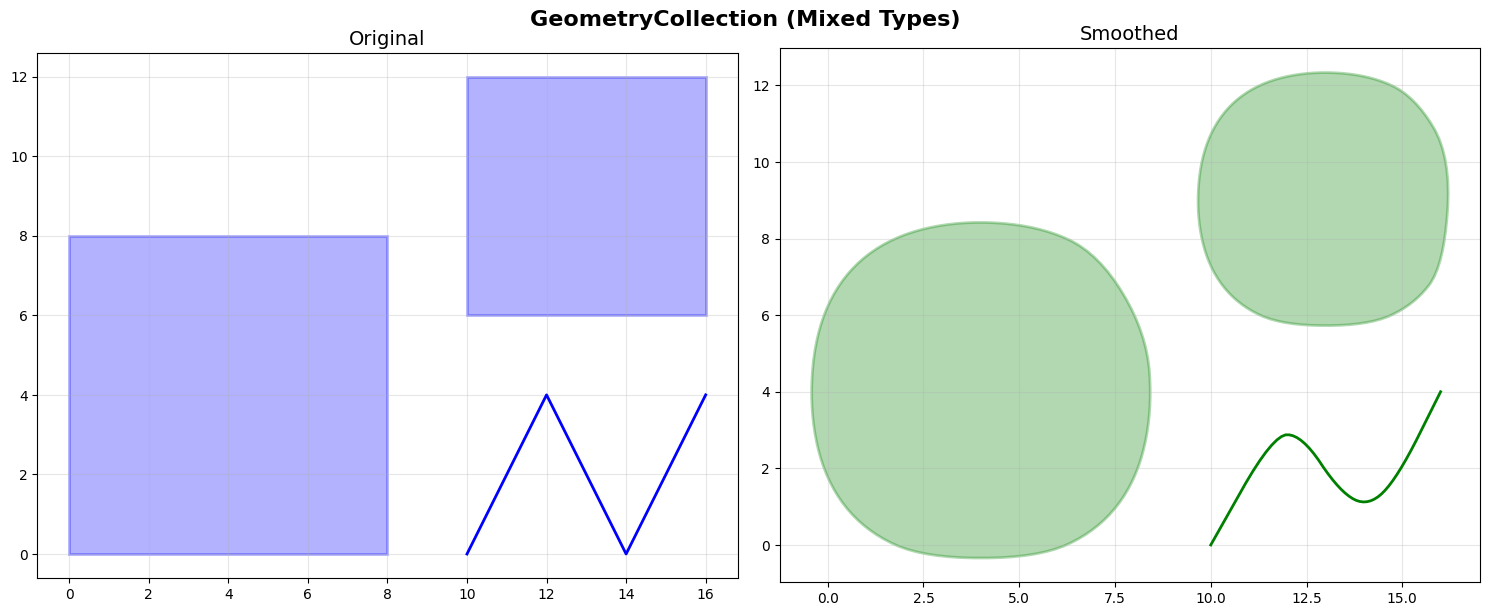


Geometry Type: GeometryCollection
Vertices: 14 → 523 (37.4x increase)
Area: 100.00 → 100.06 (Δ: 0.1%)
Length: 69.42 → 59.72
Valid: True → True



In [15]:
# Create mixed geometry collection
poly = Polygon([(0, 0), (8, 0), (8, 8), (0, 8)])
line = LineString([(10, 0), (12, 4), (14, 0), (16, 4)])
poly2 = Polygon([(10, 6), (16, 6), (16, 12), (10, 12)])
collection = GeometryCollection([poly, line, poly2])

# Smooth it
smoothed_collection = smoothify(collection, segment_length=1.0, smooth_iterations=3)

plot_comparison(
    collection,
    smoothed_collection,
    "GeometryCollection (Mixed Types)",
    show_vertices=False,
)

## 13. Comparing Different Smoothing Iterations

Same geometry with different iteration counts.

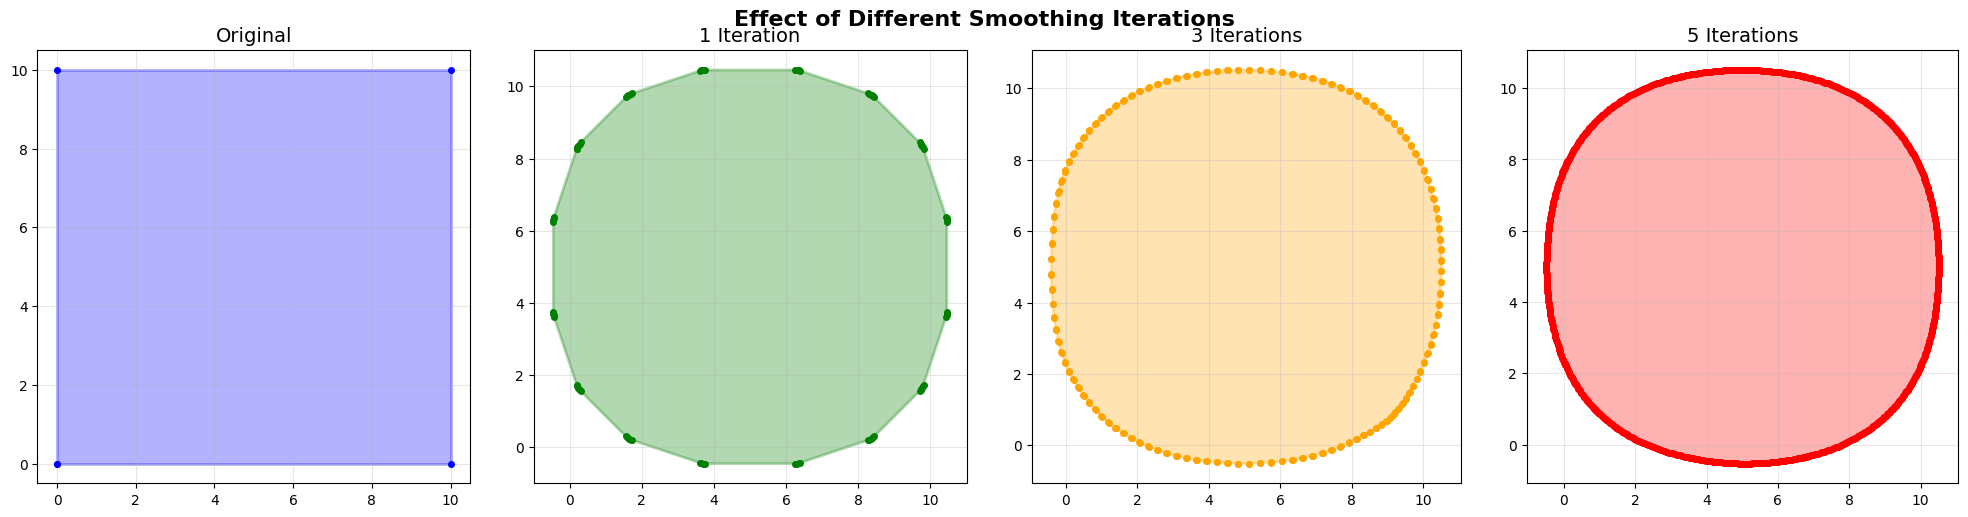

Original vertices: 5
1 iteration: 81 vertices
3 iterations: 257 vertices
5 iterations: 1025 vertices


In [16]:
# Create test polygon
test_poly = Polygon([(0, 0), (10, 0), (10, 10), (0, 10)])

# Smooth with different iterations
smooth_1 = smoothify(test_poly, segment_length=1.0, smooth_iterations=1)
smooth_3 = smoothify(test_poly, segment_length=1.0, smooth_iterations=3)
smooth_5 = smoothify(test_poly, segment_length=1.0, smooth_iterations=5)

# Plot comparison
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

plot_geometry(test_poly, axes[0], "blue", "Original", True)
plot_geometry(smooth_1, axes[1], "green", "1 Iteration", True)
plot_geometry(smooth_3, axes[2], "orange", "3 Iterations", True)
plot_geometry(smooth_5, axes[3], "red", "5 Iterations", True)

fig.suptitle("Effect of Different Smoothing Iterations", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

print(f"Original vertices: {len(test_poly.exterior.coords)}")
print(f"1 iteration: {len(smooth_1.exterior.coords)} vertices")
print(f"3 iterations: {len(smooth_3.exterior.coords)} vertices")
print(f"5 iterations: {len(smooth_5.exterior.coords)} vertices")

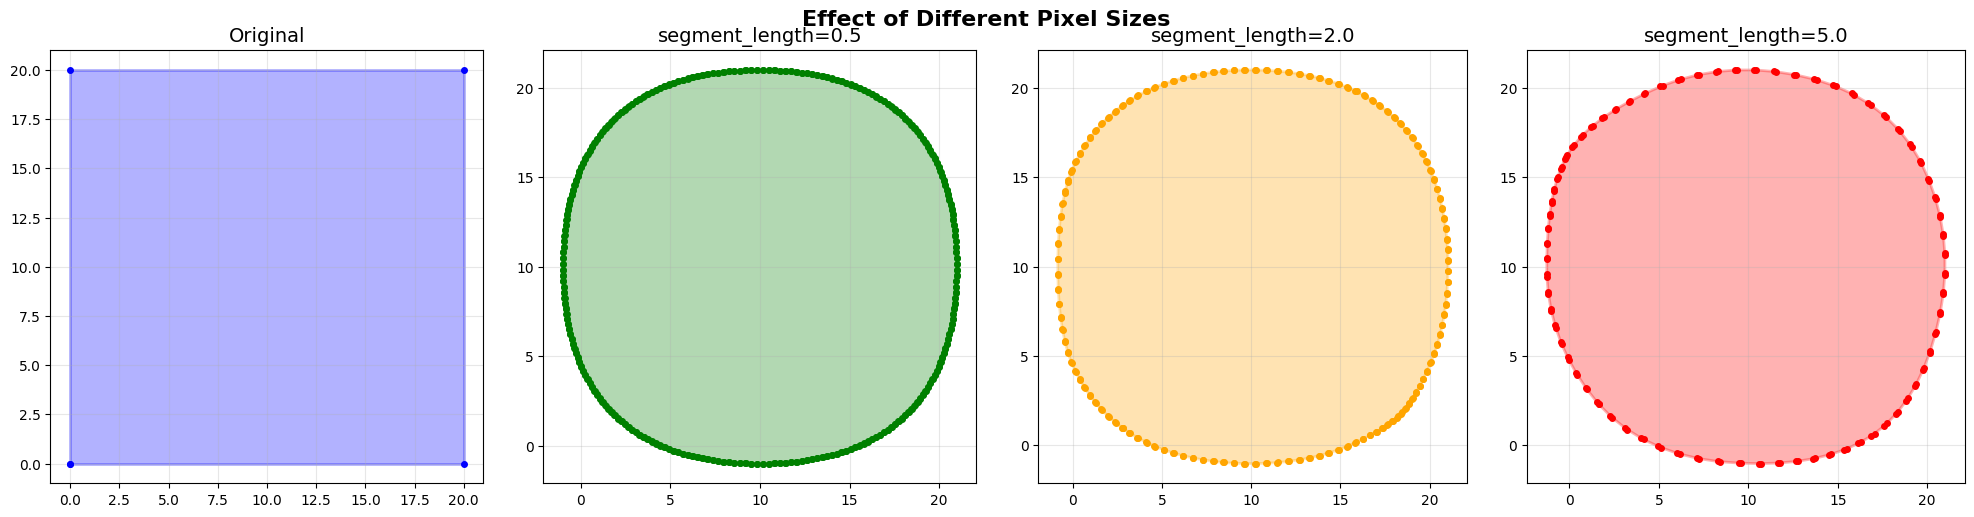

Original vertices: 5
segment_length=0.5: 513 vertices
segment_length=2.0: 257 vertices
segment_length=5.0: 146 vertices


In [17]:
# Create test polygon
test_poly = Polygon([(0, 0), (20, 0), (20, 20), (0, 20)])

# Smooth with different pixel sizes
smooth_small = smoothify(test_poly, segment_length=0.5, smooth_iterations=3)
smooth_medium = smoothify(test_poly, segment_length=2.0, smooth_iterations=3)
smooth_large = smoothify(test_poly, segment_length=5.0, smooth_iterations=3)

# Plot comparison
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

plot_geometry(test_poly, axes[0], "blue", "Original", True)
plot_geometry(smooth_small, axes[1], "green", "segment_length=0.5", True)
plot_geometry(smooth_medium, axes[2], "orange", "segment_length=2.0", True)
plot_geometry(smooth_large, axes[3], "red", "segment_length=5.0", True)

fig.suptitle("Effect of Different Pixel Sizes", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

print(f"Original vertices: {len(test_poly.exterior.coords)}")
print(f"segment_length=0.5: {len(smooth_small.exterior.coords)} vertices")
print(f"segment_length=2.0: {len(smooth_medium.exterior.coords)} vertices")
print(f"segment_length=5.0: {len(smooth_large.exterior.coords)} vertices")

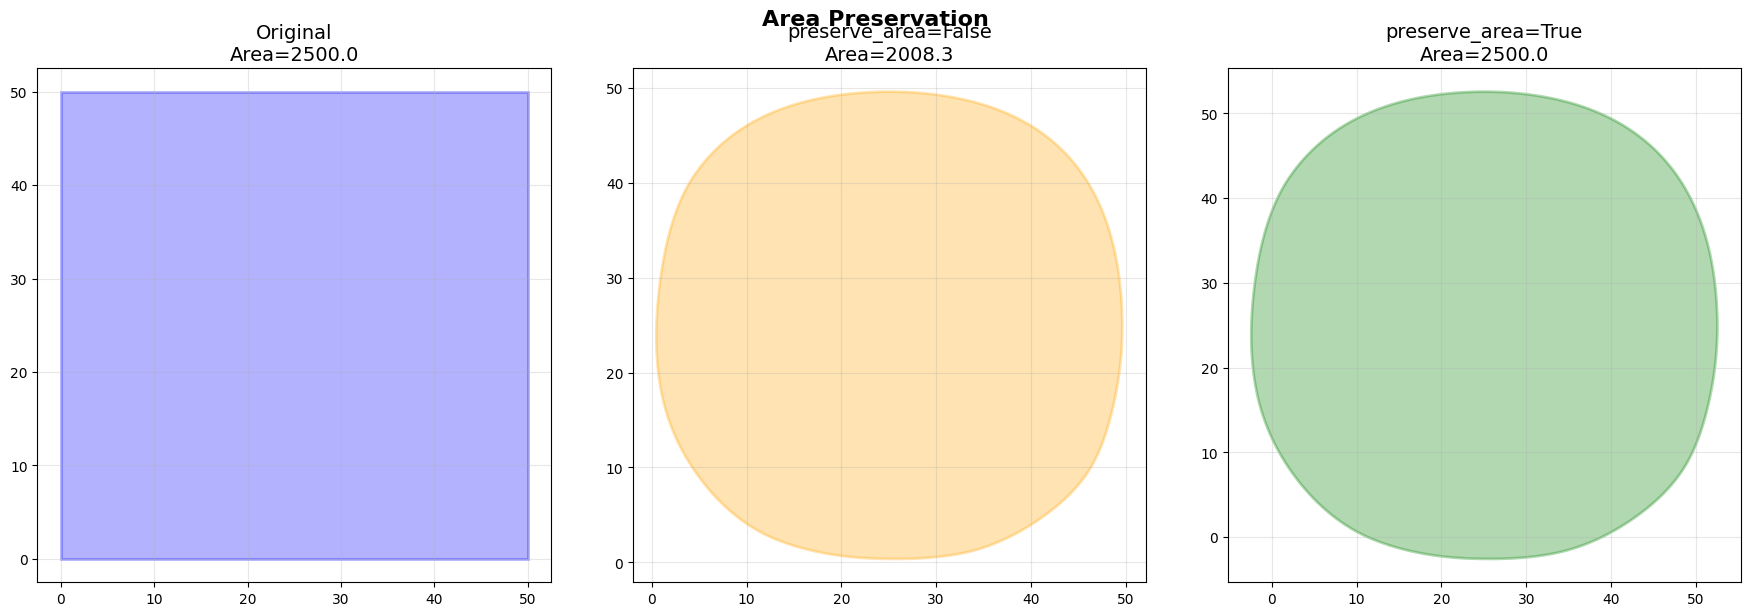

Original area: 2500.00
Without preservation: 2008.30 (Δ: 19.7%)
With preservation: 2500.01 (Δ: 0.0%)


In [18]:
# Create test polygon
test_poly = Polygon([(0, 0), (50, 0), (50, 50), (0, 50)])
original_area = test_poly.area

# Smooth with and without area preservation
smooth_no_preserve = smoothify(
    test_poly, segment_length=5.0, smooth_iterations=4, preserve_area=False
)
smooth_preserve = smoothify(
    test_poly, segment_length=5.0, smooth_iterations=4, preserve_area=True
)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_geometry(test_poly, axes[0], "blue", f"Original\nArea={original_area:.1f}", False)
plot_geometry(
    smooth_no_preserve,
    axes[1],
    "orange",
    f"preserve_area=False\nArea={smooth_no_preserve.area:.1f}",
    False,
)
plot_geometry(
    smooth_preserve,
    axes[2],
    "green",
    f"preserve_area=True\nArea={smooth_preserve.area:.1f}",
    False,
)

fig.suptitle("Area Preservation", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

print(f"Original area: {original_area:.2f}")
print(
    f"Without preservation: {smooth_no_preserve.area:.2f} (Δ: {abs(original_area - smooth_no_preserve.area) / original_area * 100:.1f}%)"
)
print(
    f"With preservation: {smooth_preserve.area:.2f} (Δ: {abs(original_area - smooth_preserve.area) / original_area * 100:.1f}%)"
)

## 15. Area Preservation

Comparing smoothing with and without area preservation.

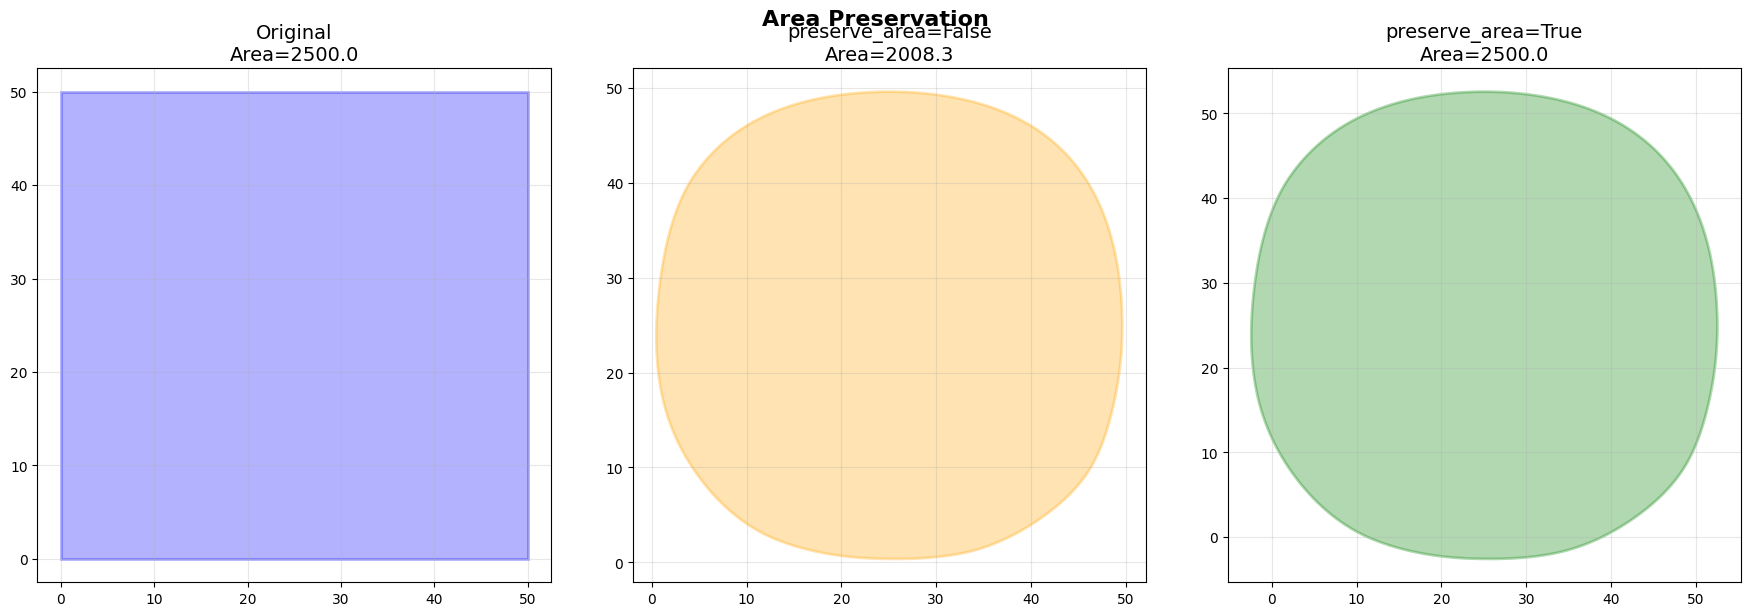

Original area: 2500.00
Without preservation: 2008.30 (Δ: 19.7%)
With preservation: 2500.01 (Δ: 0.0%)


In [19]:
# Create test polygon
test_poly = Polygon([(0, 0), (50, 0), (50, 50), (0, 50)])
original_area = test_poly.area

# Smooth with and without area preservation
smooth_no_preserve = smoothify(
    test_poly, segment_length=5.0, smooth_iterations=4, preserve_area=False
)
smooth_preserve = smoothify(
    test_poly, segment_length=5.0, smooth_iterations=4, preserve_area=True
)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_geometry(test_poly, axes[0], "blue", f"Original\nArea={original_area:.1f}", False)
plot_geometry(
    smooth_no_preserve,
    axes[1],
    "orange",
    f"preserve_area=False\nArea={smooth_no_preserve.area:.1f}",
    False,
)
plot_geometry(
    smooth_preserve,
    axes[2],
    "green",
    f"preserve_area=True\nArea={smooth_preserve.area:.1f}",
    False,
)

fig.suptitle("Area Preservation", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

print(f"Original area: {original_area:.2f}")
print(
    f"Without preservation: {smooth_no_preserve.area:.2f} (Δ: {abs(original_area - smooth_no_preserve.area) / original_area * 100:.1f}%)"
)
print(
    f"With preservation: {smooth_preserve.area:.2f} (Δ: {abs(original_area - smooth_preserve.area) / original_area * 100:.1f}%)"
)